<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [46]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [47]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [48]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

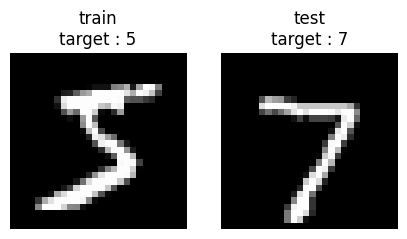

In [49]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [50]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=64, num_flows=10)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [51]:
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1080.6515808105469
Epoch :  2   -----------> Loss :  987.8847249348959
Epoch :  3   -----------> Loss :  895.8265177408854
Epoch :  4   -----------> Loss :  804.2411549886068
Epoch :  5   -----------> Loss :  714.1033782958984
Epoch :  6   -----------> Loss :  625.8276112874349
Epoch :  7   -----------> Loss :  539.1452458699545
Epoch :  8   -----------> Loss :  454.73616282145184
Epoch :  9   -----------> Loss :  374.613774617513
Epoch :  10   -----------> Loss :  295.91514587402344
Epoch :  11   -----------> Loss :  218.9482053120931
Epoch :  12   -----------> Loss :  147.10353151957193
Epoch :  13   -----------> Loss :  79.97043514251709
Epoch :  14   -----------> Loss :  14.168432394663492
Epoch :  15   -----------> Loss :  -52.85277430216471
Epoch :  16   -----------> Loss :  -114.66226259867351
Epoch :  17   -----------> Loss :  -173.52780405680338
Epoch :  18   -----------> Loss :  -227.0411605834961
Epoch :  19   -----------> Loss :  -271.51075

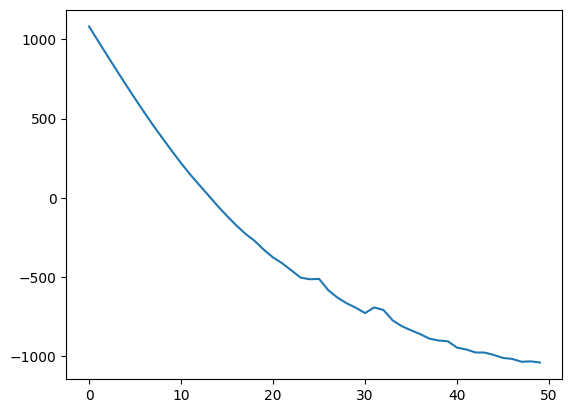

In [52]:
plt.plot(COST)

In [58]:
test = prior.sample((50,))
test

tensor([[ 0.4100,  0.1962,  2.2625,  ...,  0.8298, -0.0737,  0.4732],
        [ 0.0618,  1.0191,  1.1002,  ..., -1.4561,  0.9116, -0.1179],
        [-0.3589, -1.1141, -0.5241,  ...,  0.8060,  0.4083,  0.9773],
        ...,
        [-0.3941,  1.9192,  1.1323,  ...,  0.4111,  0.8251,  1.6982],
        [-0.4108,  0.4871,  0.0673,  ...,  0.1461,  1.6016,  0.0085],
        [ 0.7309, -0.0150,  0.1051,  ...,  0.2726,  0.8939, -0.7615]])

In [59]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 0.0088,  0.0011,  0.0204,  ...,  0.0076,  0.0028,  0.0021],
        [ 0.0094,  0.0122,  0.0130,  ..., -0.0078,  0.0082, -0.0013],
        [ 0.0011, -0.0149, -0.0022,  ...,  0.0076,  0.0048,  0.0053],
        ...,
        [ 0.0018,  0.0218,  0.0104,  ...,  0.0052,  0.0085,  0.0109],
        [ 0.0009,  0.0057,  0.0033,  ...,  0.0036,  0.0143, -0.0005],
        [ 0.0139, -0.0037,  0.0029,  ...,  0.0044,  0.0102, -0.0059]],
       grad_fn=<CopySlices>)

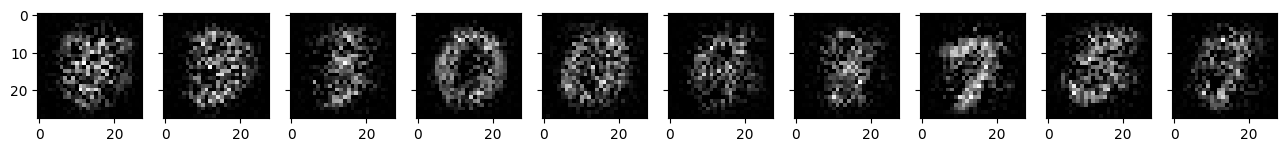

In [84]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()